In [26]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing required packages

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

## B: Logistic Regression on BreastMNIST

### B1: Loading the data

In [28]:
# Reference: https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

data_flag = 'breastmnist'

info = INFO[data_flag]
task = info['task']
num_channels = info['n_channels']
num_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [29]:
# preprocessing the data 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])  
])

# load training data
train_dataset = DataClass(split='train', transform=transform, download=True)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)

# laod validation data
val_dataset = DataClass(split='val', transform=transform, download=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=len(val_dataset), shuffle=True)

# load test data
test_dataset = DataClass(split='test', transform=transform, download=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

classes = ('negative', 'positive')  # To store the classes represented by the respective labels

Using downloaded and verified file: /Users/akankshaagarwal/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/akankshaagarwal/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/akankshaagarwal/.medmnist/breastmnist.npz


In [30]:
print(len(train_dataset))   
print("===================")
print(len(val_dataset))
print("===================")
print(len(test_dataset))

546
78
156


### B1: Displaying images from training, validation and test dataset

In [31]:
# function to display images from the dataset
def visualizeDataset(dataset, label):
    index = (dataset.labels == label).reshape(-1,)
    images = dataset.imgs[index][:10]
    labels = dataset.labels[index].reshape(-1,)[:10]

    image, axes = plt.subplots(1, 10, figsize=(9,3))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28,28),cmap="gray")

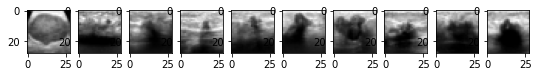

In [32]:
# Display images of category 0 from train set
visualizeDataset(train_dataset, 0)

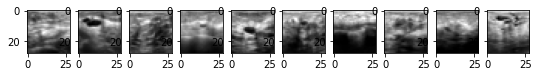

In [33]:
# Display images of category 1 from train set
visualizeDataset(train_dataset, 1)

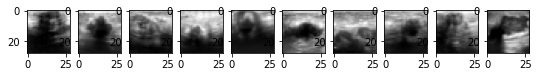

In [34]:
# Display images of category 0 from test set
visualizeDataset(test_dataset, 0)

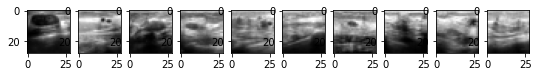

In [35]:
# Display images of category 1 from test set
visualizeDataset(test_dataset, 1)

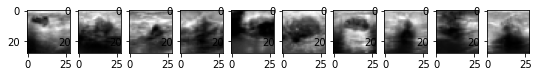

In [36]:
# Display images of category 0 from validation set
visualizeDataset(val_dataset, 0)

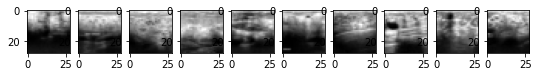

In [37]:
# Display images of category 1 from val set
visualizeDataset(val_dataset, 1)

### B2: Logistic Regression using scikit-learn

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [41]:
NUM_EPOCHS = 50
regularisation = np.logspace(start = 0.01, stop = 0.50, num = 3)
C_opts = 1/regularisation
params_grid = dict(C = C_opts)  # Parameter grid for GridSearchCV

# Hyperparameter optimization
grid_regression = GridSearchCV(LogisticRegression(penalty = 'l2'), param_grid = params_grid, cv = 4, scoring = 'accuracy')

for i, sample in enumerate(val_loader, 0):   
    val_image, val_label = sample 
    val_image = val_image.numpy().reshape(len(val_dataset), 28*28)
    val_label = val_label.numpy().ravel()
    
grid_regression.fit(val_image, val_label)
C_best = grid_regression.best_params_
print("Good choice of HyperParameter: " ,grid_regression.best_params_)
val_accuracy = grid_regression.best_score_
print("Best Score: ", val_accuracy)

Good choice of HyperParameter:  {'C': 0.31622776601683794}
Best Score:  0.793421052631579


In [42]:
# Training the model
model = LogisticRegression(penalty = 'l2', C = grid_regression.best_params_["C"], max_iter = 200)

for epoch in range(NUM_EPOCHS):
    for i, sample in enumerate(train_loader, 0):  
        train_image, train_label = sample 
        train_image = train_image.numpy().reshape(len(train_dataset), 28*28)
        train_label = train_label.numpy().ravel()
        model.fit(train_image, train_label)
        train_accuracy = model.score(train_image, train_label)  
        print("Training accuracy:- ", train_accuracy)

Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938
Training accuracy:-  0.8937728937728938


In [44]:
# Testing trained model
import sklearn.metrics as metrics
for i, sample in enumerate(test_loader, 0):   
    test_image, test_label = sample 
    test_image = test_image.numpy().reshape(len(test_dataset), 28*28)
    test_label = test_label.numpy().ravel()
    test_label_pred = model.predict(test_image)
    test_accuracy = metrics.accuracy_score(test_label, test_label_pred)
    print("Testing Accuracy:- ", test_accuracy)

Testing Accuracy:-  0.7948717948717948


### B2: Logistic Regression using Pytorch

In [45]:
# References: COM6509 Lab 6
# Defining the model
class LogisticRegression(nn.Module):
    
    def __init__(self):
        
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(784, 1)     
        
    def forward(self, x):
            y_pred = torch.sigmoid(self.linear(x))
            return y_pred

model2 = LogisticRegression()
print(model2)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=1, bias=True)
)


In [46]:
criterion=torch.nn.BCELoss()  # Using Binary Cross Entropy loss
optimizer=torch.optim.SGD(model2.parameters(),lr=0.01)  # Using Stochastic Gradient Descent Opitmizer

In [47]:
# Hyperparameter optimization

data_iter = iter(val_loader)        # TODO: Try not to use this loop
val_images, val_labels = data_iter.next()
val_images = val_images.reshape(len(val_dataset), 28*28)
val_labels = val_labels.to(torch.float)

for l2_lambda in regularisation:  # Using the same options for regularisation as in previous part 
    l2_regularization = torch.tensor(0.)
    optimizer.zero_grad()
    val_labels_pred = model2(val_images).round()
    loss = criterion(val_labels_pred, val_labels)
    
    for param in model2.parameters():
        l2_regularization +=  param.pow(2.0).sum()
    
    loss = loss + l2_lambda * l2_regularization
    loss.backward(retain_graph = True)
    optimizer.step()
        
    with torch.no_grad():  # Omitting gradients while calculating accuracy
            val_accuracy_pt = (val_labels_pred.eq(val_labels).sum())/float(len(val_labels))
            print("Validation Accuracy:- ", val_accuracy_pt.item())


Validation Accuracy:-  0.7179487347602844
Validation Accuracy:-  0.7179487347602844
Validation Accuracy:-  0.7179487347602844


In [48]:
# Training the model

train_accuracy_pt = torch.tensor(0.)

data_iter = iter(train_loader)  
train_images, train_labels = data_iter.next()
train_images = train_images.reshape(len(train_dataset), 28*28)
train_labels = train_labels.to(torch.float)

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    train_labels_pred = model2(train_images)
    loss = criterion(train_labels_pred, train_labels)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():  # Omitting the use of gradient while calculating accuracy
            train_labels_pred = train_labels_pred.round()
            train_accuracy_pt = (train_labels_pred.eq(train_labels).sum())/float(len(train_labels))
            print("Training Accuracy:- ", train_accuracy_pt.item())

Training Accuracy:-  0.6941391825675964
Training Accuracy:-  0.7197802066802979
Training Accuracy:-  0.7179487347602844
Training Accuracy:-  0.721611738204956
Training Accuracy:-  0.721611738204956
Training Accuracy:-  0.721611738204956
Training Accuracy:-  0.7234432101249695
Training Accuracy:-  0.7234432101249695
Training Accuracy:-  0.7234432101249695
Training Accuracy:-  0.7234432101249695
Training Accuracy:-  0.7252747416496277
Training Accuracy:-  0.7252747416496277
Training Accuracy:-  0.7252747416496277
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7271062135696411
Training Accuracy:-  0.7252747416496277
Training Accuracy:-  0.7252747416496277
Tra

In [49]:
# Testing the model
data_iter = iter(test_loader)
test_images, test_labels = data_iter.next()

test_images = test_images.reshape(len(test_dataset), 28*28)
test_labels = test_labels.to(torch.float)

test_labels_pred = model2(test_images).round()
test_accuracy_pt = (test_labels_pred.eq(test_labels).sum())/float(len(test_labels))
print(test_accuracy_pt.item())

0.7371794581413269


### B3: Performance Comparison

In [50]:
print("M1", train_accuracy, train_accuracy_pt.item())
print("M2", val_accuracy, val_accuracy_pt.item())
print("M3", test_accuracy, test_accuracy_pt.item())

M1 0.8937728937728938 0.7252747416496277
M2 0.793421052631579 0.7179487347602844
M3 0.7948717948717948 0.7371794581413269


In [51]:
accuracy_skl = [train_accuracy, val_accuracy, test_accuracy]
accuracy_pt = [train_accuracy_pt.item(), val_accuracy_pt.item(), test_accuracy_pt.item()]

<BarContainer object of 3 artists>

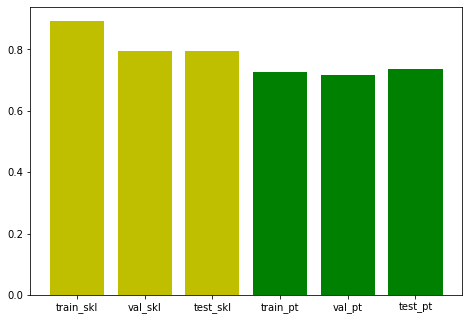

In [52]:
# Plotting a bar graph to compare performance
fig1 = plt.figure()
axes = fig1.add_axes([0,0,1,1])
axes.bar(['train_skl', 'val_skl', 'test_skl'], accuracy_skl, color = 'y')  #TODO look for a way to show the same metrics alongside
axes.bar(['train_pt', 'val_pt', 'test_pt'], accuracy_pt, color = 'g')

#### Observations:
* The training accuracy is greater with scikit-learn as compared to with PyTorch.
* The prediction accuracy is almost similar with both the models.

## C: Convolutional Neural Networks on OctaMNIST

### C1: Loading the data

In [55]:
# Reference: https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

NUM_EPOCHS = 50
BATCH_SIZE = 64

data_flag = 'octmnist'

info = INFO[data_flag]
task = info['task']
num_channels = info['n_channels']
num_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [56]:
# Preprocessing the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load training data
train_dataset = DataClass(split='train', transform=transform, download=True)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# laod validation data
val_dataset = DataClass(split='val', transform=transform, download=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# load test data
test_dataset = DataClass(split='test', transform=transform, download=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

classes = ('choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal') # To store classes represented by the respective labels

Using downloaded and verified file: /Users/akankshaagarwal/.medmnist/octmnist.npz
Using downloaded and verified file: /Users/akankshaagarwal/.medmnist/octmnist.npz
Using downloaded and verified file: /Users/akankshaagarwal/.medmnist/octmnist.npz


In [57]:
print(len(train_dataset))
print("===================")
print(len(val_dataset))
print("===================")
print(len(test_dataset))

97477
10832
1000


### C1: Displaying images from Training dataset

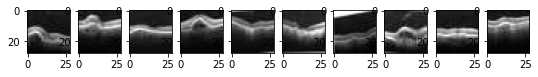

In [58]:
# Display images of category 0 from train set
visualizeDataset(train_dataset, 0)

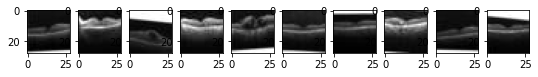

In [59]:
# Display images of category 1 from train set
visualizeDataset(train_dataset, 1)

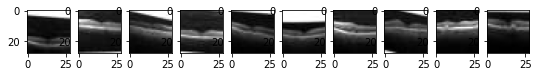

In [60]:
# Display images of category 2 from train set
visualizeDataset(train_dataset, 2)

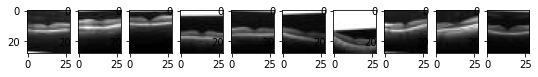

In [61]:
# Display images of category 3 from train set
visualizeDataset(train_dataset, 3)

### C2: CNN with 2 Convolutional Layers and 2 Fully Connected Layers 

In [83]:
# Reference: COM6509 Lab-7
# Defining the model

import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 1) #1: #input channel; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 84)
        self.fc2 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

CNN_model1 = CNN()

In [84]:
criterion = nn.CrossEntropyLoss() # Using Cross Entropy Loass
optimizer = optim.SGD(CNN_model1.parameters(), lr=0.004, momentum = 0.9) # Using Stochastic Gradient Descent optimizer

In [85]:
import time
# Training the model

start_time = time.time()
running_loss = 0.0
for epoch in range(10):
    
    for i, sample in enumerate(train_loader, 0):
        train_images, train_labels = sample
        train_labels = train_labels.to(torch.long)
        optimizer.zero_grad()
        train_labels_pred = CNN_model1(train_images)
        loss = criterion(train_labels_pred, torch.max(train_labels,1)[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
# Calculate Training Time
time_cnn1 = round(time.time()-start_time, 3)
print("Training Completed")

Training Completed


In [86]:
# Saving our trained network
PATH = 'data/mnist_net.pth'
torch.save(CNN_model1.state_dict(), PATH)

In [87]:
loadCNN = CNN()
loadCNN.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [92]:
# Calculating Training Accuracy
data_iter = iter(train_loader)
images, labels = data_iter.next()
out = loadCNN(images)
_, pred = torch.max(out, 1)

print(" ".join("%5s, " % classes[labels[j]] for j in range(BATCH_SIZE)))
print("==================")
print(" ".join("%5s, " % classes[pred[j]] for j in range(BATCH_SIZE)))

with torch.no_grad():
        train_accuracy = (pred.eq(labels).sum())/float(len(labels))
        print("Training Accuracy:- ", train_accuracy.item())

choroidal neovascularization,  drusen,  normal,  choroidal neovascularization,  choroidal neovascularization,  normal,  choroidal neovascularization,  normal,  normal,  choroidal neovascularization,  choroidal neovascularization,  drusen,  normal,  drusen,  normal,  normal,  choroidal neovascularization,  normal,  diabetic macular edema,  normal,  choroidal neovascularization,  normal,  normal,  drusen,  normal,  choroidal neovascularization,  normal,  diabetic macular edema,  normal,  normal,  diabetic macular edema,  diabetic macular edema,  choroidal neovascularization,  normal,  choroidal neovascularization,  normal,  choroidal neovascularization,  normal,  normal,  choroidal neovascularization,  choroidal neovascularization,  diabetic macular edema,  normal,  choroidal neovascularization,  normal,  normal,  diabetic macular edema,  diabetic macular edema,  normal,  choroidal neovascularization,  choroidal neovascularization,  choroidal neovascularization,  normal,  normal,  diabet

In [117]:
# Hyperparameter Optimization
data_iter = iter(val_loader)
    
val_images, val_labels = data_iter.next()
val_labels_pred = loadCNN(val_images) 
_, pred = torch.max(out, 1)

with torch.no_grad():
    loadCNN.eval()
    labels = torch.max(val_labels,1)[0]
    loss = F.cross_entropy(val_labels_pred, labels) 
    val_accuracy = (pred.eq(val_labels).sum())/float(len(val_labels)) 
    print("Validation_Accuracy", val_accuracy.item())



Validation_Accuracy 25.375


In [118]:
# Testing the model

data_iter = iter(test_loader)
test_images, test_labels = data_iter.next()

test_labels_pred = loadCNN(test_images).round()
with torch.no_grad():
    test_accuracy = (test_labels_pred.eq(test_labels).sum())/float(len(test_labels))
    print("Test Accuarcy:- ", test_accuracy)

Test Accuarcy:-  tensor(0.8906)


### C2: CNN with 3 Convolutional and 3 Fully Connected Layers

In [119]:
# Model Definiiton
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2) #1: #input channel; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 28, 5)
        self.fc1 = nn.Linear(28 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = F.sigmoid(self.conv2(x))
        x = F.sigmoid(self.conv3(x))
        x = x.view(-1, 28 * 6 * 6)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

CNN_model2 = CNN()

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_model2.parameters(), lr=0.004, momentum = 0.9)

In [122]:
# Training the model

start_time = time.time()
running_loss = 0.0
for epoch in range(10):
    
    for i, sample in enumerate(train_loader, 0):
        train_images, train_labels = sample
        train_labels = train_labels.to(torch.long)
        optimizer.zero_grad()
        train_labels_pred = CNN_model2(train_images)
        loss = criterion(train_labels_pred, torch.max(train_labels,1)[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
# Calculating Training Time
time_cnn2 = round(time.time()-start_time, 3)
print("Training Completed")

Training Completed


In [123]:
PATH = 'data/mnist_net.pth'  # Save the trained model
torch.save(CNN_model2.state_dict(), PATH)

In [124]:
loadCNN2 = CNN()
loadCNN2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [125]:
# Training Accuracy
images, labels = data_iter.next()
out = loadCNN2(images)
_, pred = torch.max(out, 1)

print(" ".join("%5s, " % classes[labels[j]] for j in range(BATCH_SIZE)))
print("==================")
print(" ".join("%5s, " % classes[pred[j]] for j in range(BATCH_SIZE)))

with torch.no_grad():
        train_accuracy2 = (pred.eq(labels).sum())/float(len(labels))
        print("Training Accuracy:- ",train_accuracy2.item())

diabetic macular edema,  diabetic macular edema,  choroidal neovascularization,  diabetic macular edema,  choroidal neovascularization,  choroidal neovascularization,  normal,  choroidal neovascularization,  diabetic macular edema,  choroidal neovascularization,  drusen,  choroidal neovascularization,  diabetic macular edema,  diabetic macular edema,  normal,  choroidal neovascularization,  diabetic macular edema,  choroidal neovascularization,  normal,  normal,  choroidal neovascularization,  drusen,  diabetic macular edema,  choroidal neovascularization,  drusen,  drusen,  normal,  choroidal neovascularization,  normal,  drusen,  normal,  drusen,  diabetic macular edema,  choroidal neovascularization,  diabetic macular edema,  choroidal neovascularization,  drusen,  diabetic macular edema,  diabetic macular edema,  diabetic macular edema,  diabetic macular edema,  drusen,  diabetic macular edema,  diabetic macular edema,  normal,  choroidal neovascularization,  drusen,  choroidal neo

In [127]:
# Hyperparameter Optimization
data_iter = iter(val_loader)   
val_images, val_labels = data_iter.next()
val_labels_pred = loadCNN2(val_images)
_, pred = torch.max(val_labels_pred, 1)
    
with torch.no_grad():
    loadCNN.eval()                    
    loss = F.cross_entropy(val_labels_pred, torch.max(val_labels,1)[0]) 
    val_accuracy2 = (pred.eq(val_labels).sum())/float(len(val_labels)) 
    print("Validation Accuracy", val_accuracy2.item())

Validation Accuracy 27.0


In [128]:
# Testing the model
data_iter = iter(test_loader)
test_images, test_labels = data_iter.next()

test_labels_pred = loadCNN2(test_images).round()
with torch.no_grad():
    test_accuracy2 = (test_labels_pred.eq(test_labels).sum())/float(len(test_labels))
    print("Testing Accuracy:- ",test_accuracy2)

Testing Accuracy:-  tensor(0.4062)


In [129]:
print("M1", train_accuracy.item(), train_accuracy2.item())
print("M2", val_accuracy.item(), val_accuracy2.item())
print("M3", test_accuracy.item(), test_accuracy2.item()) 
print("M4", time_cnn1, time_cnn2)

M1 26.734375 11.0
M2 25.375 27.0
M3 0.890625 0.40625
M4 221.929 391.531


In [130]:
accuracy_1 = [train_accuracy.item(), val_accuracy.item(), test_accuracy.item(), time_cnn1]
accuracy_2 = [train_accuracy2.item(), val_accuracy2.item(), test_accuracy2.item(), time_cnn2]

<BarContainer object of 4 artists>

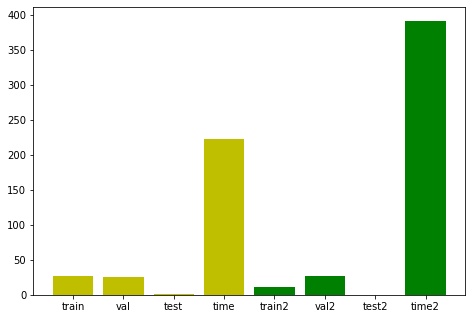

In [131]:
fig1 = plt.figure()
axes = fig1.add_axes([0,0,1,1])
axes.bar(['train', 'val', 'test', 'time'], accuracy_1, color = 'y')  #TODO look for a way to show the same metrics alongside
axes.bar(['train2', 'val2', 'test2', 'time2'], accuracy_2, color = 'g')

#### Observations:
* The Training Time is __more__ for model 1 than model 2
* The validation accuracy was almost same for both


## D: Unsupervised Learning on Fashion-MNIST 

### D1. Dimensionality reduction and clustering

In [5]:
# Reference: COM6509 Lab-7
# Loading test data for FashionMNIST
from torchvision import datasets

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean = [.5], std = [.5]) ])

# Load test data for categories 5 and 7 
test_data = datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)
index = (test_data.targets == 5) | (test_data.targets == 7)
test_data.targets = test_data.targets[index]
test_data.data = test_data.data[index]

print(len(test_data))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

2000


In [6]:
test_dataset = list(test_data)

#### Principal Component Analysis

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step-1: Scaling the data
scaler = StandardScaler()

test_dataset_images = np.array(test_dataset[:][0][0].numpy()).reshape(1, 28*28)

for i in range(1, len(test_dataset)):
    test_dataset_images = np.append(test_dataset_images, np.array(test_dataset[:][i][0].numpy()).reshape(1, 28*28), axis=0)

test_dataset_images = scaler.fit_transform(test_dataset_images)
print("Shape before Applying PCA:-", test_dataset_images.shape)

# Step-2: Applying PCA on the data
pca = PCA(n_components = 30, random_state = 42)
test_dataset_pca = pca.fit_transform(test_dataset_images)

print("Shape after Applying PCA:- ",test_dataset_pca.shape)

Shape before Applying PCA:- (2000, 784)
Shape after Applying PCA:-  (2000, 30)


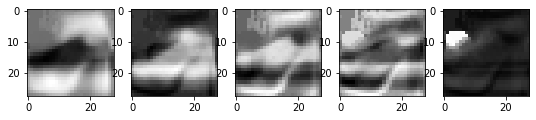

In [8]:
# Step-3: Visualizing the top 5 eigenvectors

image, axes = plt.subplots(1, 5, figsize=(9,3))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(28,28),cmap="gray")

In [9]:
# Create separate dataset for class 5
class_5 = datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)
index = (class_5.targets == 5)
class_5.targets = class_5.targets[index]
class_5.data = class_5.data[index]

# Create separate dataset for class 7
class_7 = datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)
index = (class_7.targets == 7)
class_7.targets = class_7.targets[index]
class_7.data = class_7.data[index]

print("Length of class 5:- ",len(class_5), "\nLength of class 7:-", len(class_7))

Length of class 5:-  1000 
Length of class 7:- 1000


In [10]:
class_dataset = list(class_5)[:5] + list(class_7)[:5]

#Processs the class dataset for visualizing
class_dataset_images = np.array(class_dataset[:][0][0].numpy()).reshape(1, 28*28)

for i in range(1, len(class_dataset)):
    class_dataset_images = np.append(class_dataset_images, np.array(class_dataset[:][i][0].numpy()).reshape(1, 28*28), axis=0)

class_dataset_images = scaler.fit_transform(class_dataset_images)

#Apply PCA
class_pca = pca.transform(class_dataset_images)
print("Shape after PCA:- ",class_pca.shape)

Shape after PCA:-  (10, 30)


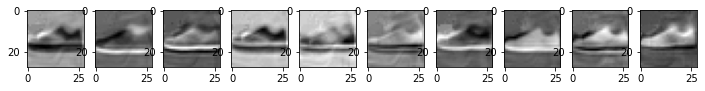

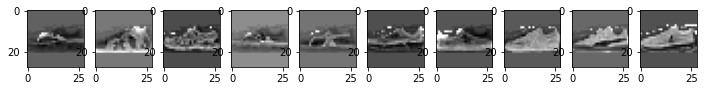

In [11]:
# Step-4: Reconstruct images
reconstructed = pca.inverse_transform(class_pca)  
plt.figure('Reconstructed', figsize=(12, 12))
for i in range(1,11):
    plt.subplot(1, 10, i)
    plt.imshow(reconstructed[i-1].reshape((28, 28)),cmap="gray")
plt.show() 

# Show the original images
plt.figure('Original', figsize=(12, 12))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(class_dataset_images[i-1].reshape((28, 28)),cmap="gray")
plt.show()

In [12]:
# Apply pca for 2 principal components
pca_2 = PCA(n_components= 2)
test_pca2 = pca_2.fit_transform(test_dataset_images)

# Extract the two components in different lists
pc1 = [row[0] for row in test_pca2]
pc2 = [row[1] for row in test_pca2]

# Get labels of the data
labels = [row[1] for row in test_dataset]

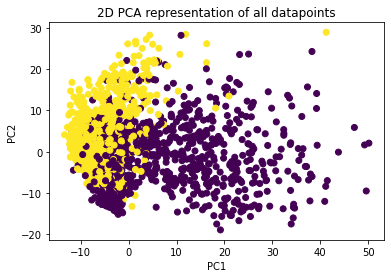

In [13]:
# Step-5 Plotting the first two Principal Components 
plt.scatter(pc1, pc2, c = labels)
plt.title("2D PCA representation of all datapoints")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

#### Spectral Clustering

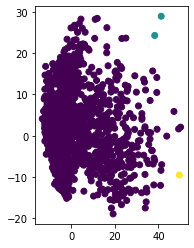

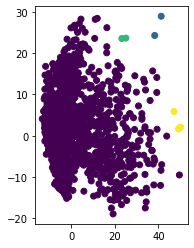

In [14]:
# Step-6 Spectral Clustering
from sklearn.cluster import SpectralClustering

def SpectralClusteringStep(num_clusters):
    sc = SpectralClustering(n_clusters = num_clusters, affinity = 'rbf', assign_labels = 'kmeans')
    test_sc = sc.fit(test_pca2)
    labels = test_sc.labels_
    plt.scatter(test_pca2[:,0], test_pca2[:,1], c=labels)
    plt.show()
    
    
# Spectral Clustering With 3 clusters
plt.subplot(1, 2, 1)
SpectralClusteringStep(3)


# Spectral Clustering with 4 clusters
plt.subplot(1, 2, 2)
SpectralClusteringStep(4)

#### Auto-encoder

In [15]:
# Reference: COM6509 Lab-8

# Define the model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            nn.ReLU(),
            nn.Conv2d(64, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
my_encoder = Autoencoder()
print(my_encoder)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): Sigmoid()
  )
)


In [18]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(my_encoder.parameters(), lr=0.01, weight_decay=1e-5)

In [ ]:
# Reference: COM6509 Lab-8
batch_size=128
learning_rate=1e-3
max_epochs = 20

train_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Storage
output_images = []
loss_per_epoch = []

# Training the encoder
for epoch in range(max_epochs):
    for data in train_loader:
        img, label = data
        optimizer.zero_grad()
        recon_img = my_encoder(img)
        loss = criterion(recon_img, img)
        loss.backward()
        optimizer.step()            
    if (epoch % 2) != 0:
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    output_images.append((epoch, img, recon_img),)
    loss_per_epoch.append(float(loss))

Epoch:2, Loss:0.8079
Epoch:4, Loss:0.7942
Epoch:6, Loss:0.7860
Epoch:8, Loss:0.7929
Epoch:10, Loss:0.8048
Epoch:12, Loss:0.7944


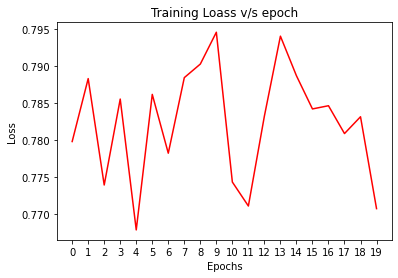

In [749]:
# Plotting training loss per epoch

epochs = range(20)
plt.figure()
plt.plot(epochs, loss_per_epoch, 'r')
plt.xticks(epochs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loass v/s epoch")
plt.show()

#### Observations:

* Majority of the datapoints belong to same cluster while performing Spectral Clustering.
* The reconstructed image is almost sufficient to classify the images in labels.